In [62]:
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cmocean as cm
from xgcm import Grid
from scipy.signal import find_peaks


In [43]:
ave = False ## True means use 5 daily average rather than hourly prog
def open_files(folder):
    base = folder
    if ave:
        prog = xr.open_dataset(base + '/ave_prog.nc')
    else:
        prog = xr.open_dataset(base + '/prog.nc')
    ocean_static = xr.open_dataset(base + "/ocean_geometry.nc")
    return prog, ocean_static
def open_IC(folder):
    base = folder
    IC = xr.open_dataset(base + '/MOM_IC.nc')
    return IC
def open_Initialstate(folder):
    base = folder
    IC = xr.open_dataset(base + '/Initial_state.nc')
    return IC


In [44]:
folder = 'simpleshelftest2'
def plot(ax,yy0,tt,i,variable,varname,vmin1,vmax1,cmap,ymax):
    prog, ocean_static = open_files(folder)
    grid = Grid(prog,coords={"x":{"center":"xh","outer":"xq"},
                             "y":{"center":"yh","outer":"yq"},
                             "z":{"center":"zl","outer":"zi"}},periodic=False)
    file_name = folder
    label = folder
    depth = grid.interp(prog.e,'x')
    lon = ocean_static.geolonb
    dataplot = variable

    xx = lon
    if varname == "uo": dataplot = dataplot[:,:,:,:-1]
    levels = np.linspace(vmin1, vmax1, 51)
    yy = depth[:,:,yy0,:]
    z_levels = yy.shape[1]
    yi = np.linspace(0,5000,z_levels) #Dummy, just for have z_levels
    # plot variable in colours
    xi, yyi = np.meshgrid(xx[yy0,:], yi) #We repeat the horizontal part of the grid by the number of zlevels
    #cax = ax.contourf(xi,yy[tt,...],dataplot[tt,:,yy0,:],levels = levels, cmap = cmap, extend = 'both',corner_mask = False)
    #print(xi.shape)
    #print(yy[tt,...].shape)
    #print(dataplot[tt,:,yy0,:].shape)
    cax = ax.pcolormesh(xi,yy[tt,...],dataplot[tt,:,yy0,:],vmin = vmin1, vmax = vmax1, cmap = cmap)
    
    plt.colorbar(cax, ax = ax, label = varname)
    
    ## plot interface heights
    i_heights = prog.e # this is 'Interface Height Relative to Mean Sea Level'
    # do for one time
    i_heights = i_heights.isel(Time = tt)
    # take zonal mean
    i_heights = i_heights.isel(yh = yy0)#.mean('xh')

    # plot a line of layer depths, layer by layer
    nz = len(i_heights.zi)
    xh = prog.xh

    for i in range(nz):
        ax.plot(xh,i_heights[i], color = 'k', linewidth = 0.5)
    
    ax.set_ylim(ymin=-ymax,ymax=0)
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel('x (km)')
    ax.set_title(varname+' , ' +label)
    


# simple shelf test for Salt initial conditions

(Temp is constant)

time = 0001-01-01 01:00:00


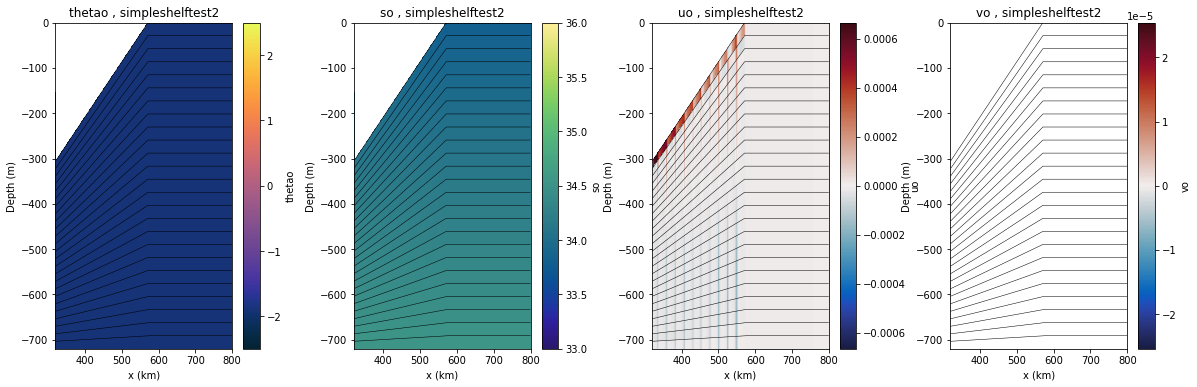

In [45]:
label = 'simpleshelftest2'
prog, ocean_static = open_files(label)
IC = open_IC(label)
fig,axes = plt.subplots(figsize = (20,6), nrows = 1, ncols = 4)
time = 0 ## 5 days
x = 0
ymax = 720
#plot temp
plot(axes[0],x,time,0,prog.temp,"thetao",-2.5,2.5,cm.cm.thermal,ymax)
# plot salinity
plot(axes[1],x,time,0,prog.salt,"so",33,36,cm.cm.haline,ymax)
# plot u
scale = np.abs(prog.isel(Time = time).u).max().values
if scale < 1e-12: ## in case of very small number
    scale = 1e-12
scale = scale#/10
plot(axes[2],x,time,0,prog.u,"uo",-scale,scale,cm.cm.balance,ymax)
# plot v
scale = np.abs(prog.isel(Time = time).v).max().values
if scale < 1e-12: ## in case of very small number
    scale = 1e-12
scale = scale#/10
plot(axes[3],x,time,0,prog.v,"vo",-scale,scale,cm.cm.balance,ymax)

plt.subplots_adjust(wspace = 0.35, hspace = 0.3)

print('time = '+str(prog.isel(Time = time).Time.values))

#### Compare to linear gradient, should be 33.8 to 34.55 over a distance 720m. Use centre depth of layers.

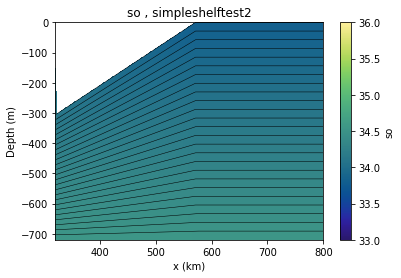

In [46]:
fig, ax = plt.subplots()
prog, ocean_static = open_files(label)
ideal_salt = xr.zeros_like(prog.salt) + (prog.e.isel(zi = 0)-prog.h.cumsum('zl')+prog.h/2)*(34.55-33.8)/(-720) + 33.8
plot(ax,x,time,0,ideal_salt,"so",33,36,cm.cm.haline,ymax)


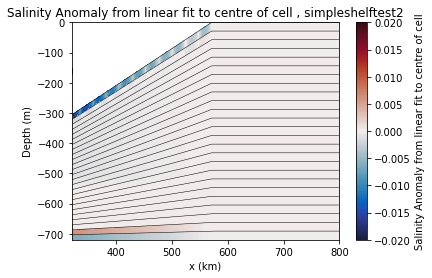

In [47]:
fig, ax = plt.subplots()
plot(ax,x,time,0,prog.salt-ideal_salt,"Salinity Anomaly from linear fit to centre of cell",-0.02,0.02,cm.cm.balance,ymax)


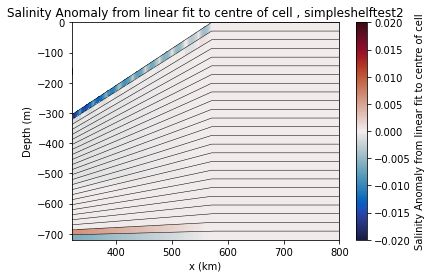

In [48]:
## use IC 

fig, ax = plt.subplots()
prog, ocean_static = open_files(label)
IC = open_IC(label)
x = -1

ideal_salt = xr.zeros_like(IC.Salt) + (IC.eta.isel(Interface = 0)-IC.h.cumsum('Layer')+IC.h/2)*(34.55-33.8)/(-720) + 33.8
plot(ax,x,time,0,IC.Salt-ideal_salt,"Salinity Anomaly from linear fit to centre of cell",-0.02,0.02,cm.cm.balance,ymax)


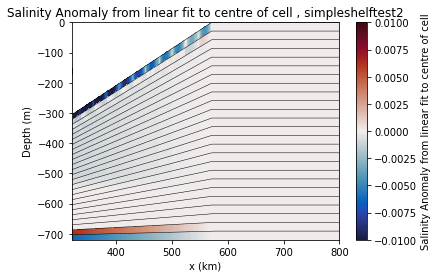

In [61]:
## use IC , integrate from the bottom

fig, ax = plt.subplots()
prog, ocean_static = open_files(label)
IC = open_IC(label)
x = -1

ideal_salt = xr.zeros_like(IC.Salt) +  (-720 + (IC.h.sum('Layer')-IC.h.cumsum('Layer'))+IC.h/2)*(33.8-34.55)/(720) + 33.8
plot(ax,x,time,0,IC.Salt-ideal_salt,"Salinity Anomaly from linear fit to centre of cell",-0.01,0.01,cm.cm.balance,ymax)


Text(0.5, 1.0, 'Salinity, top layer')

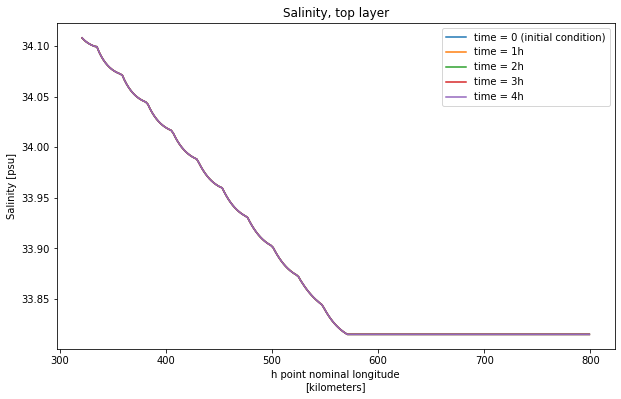

In [8]:
label = 'simpleshelftest2'
prog, ocean_static = open_files(label)
IC = open_IC(label)

fig,ax = plt.subplots(figsize = (10,6))
IC.Salt.isel(Time = 0).isel(Layer = 0, lath = 10).plot(label = 'time = 0 (initial condition)')

prog.salt.isel(Time = 0).isel(zl = 0, yh = 10).plot(label = 'time = 1h')

prog.salt.isel(Time = 1).isel(zl = 0, yh = 10).plot(label = 'time = 2h')

prog.salt.isel(Time = 2).isel(zl = 0, yh = 10).plot(label = 'time = 3h')

prog.salt.isel(Time = 3).isel(zl = 0, yh = 10).plot(label = 'time = 4h')

plt.legend()

plt.title('Salinity, top layer')



Text(0.5, 1.0, 'Salinity, top layer')

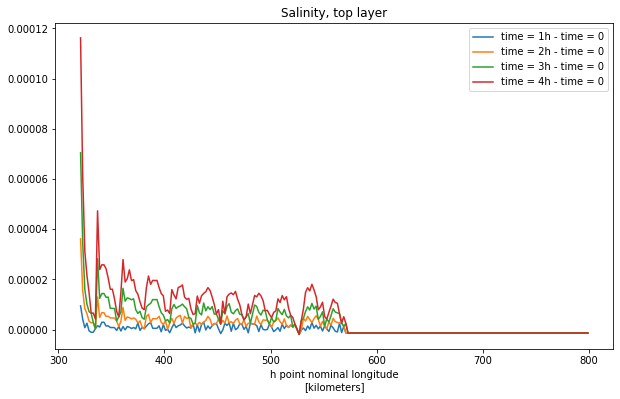

In [9]:
label = 'simpleshelftest2'
prog, ocean_static = open_files(label)
IC = open_IC(label)

fig,ax = plt.subplots(figsize = (10,6))

IC_Salt = IC.Salt.isel(Time = 0).isel(Layer = 0, lath = 10).rename({'lonh':'xh'})
#IC_Salt.plot(label = 'time = 0 (initial condition)')

(prog.salt.isel(Time = 0).isel(zl = 0, yh = 10)-IC_Salt).plot(label = 'time = 1h - time = 0')

(prog.salt.isel(Time = 1).isel(zl = 0, yh = 10)-IC_Salt).plot(label = 'time = 2h - time = 0')

(prog.salt.isel(Time = 2).isel(zl = 0, yh = 10)-IC_Salt).plot(label = 'time = 3h - time = 0')

(prog.salt.isel(Time = 3).isel(zl = 0, yh = 10)-IC_Salt).plot(label = 'time = 4h - time = 0')

plt.legend()

plt.title('Salinity, top layer')



Text(0.5, 1.0, 'Layer thickness, top layer')

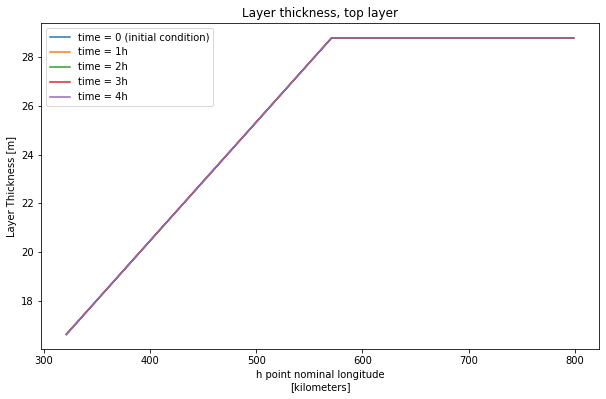

In [10]:
label = 'simpleshelftest2'
prog, ocean_static = open_files(label)
IC = open_IC(label)
fig,ax = plt.subplots(figsize = (10,6))
IC.h.isel(Time = 0).isel(Layer = 0, lath = 10).plot(label = 'time = 0 (initial condition)')

prog.h.isel(Time = 0).isel(zl = 0, yh = 10).plot(label = 'time = 1h')

prog.h.isel(Time = 1).isel(zl = 0, yh = 10).plot(label = 'time = 2h')

prog.h.isel(Time = 2).isel(zl = 0, yh = 10).plot(label = 'time = 3h')

prog.h.isel(Time = 3).isel(zl = 0, yh = 10).plot(label = 'time = 4h')

plt.legend()

plt.title('Layer thickness, top layer')


Text(0.5, 1.0, 'Layer thickness, top layer')

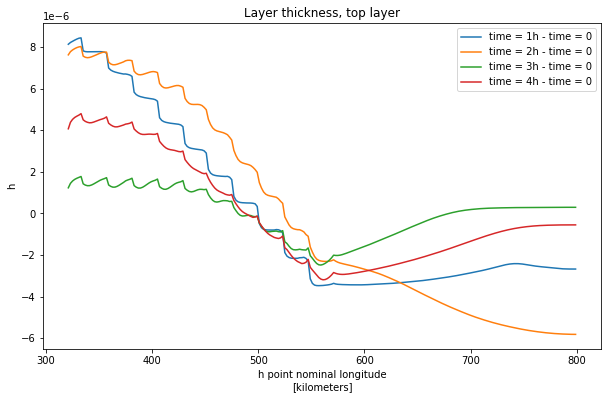

In [11]:
label = 'simpleshelftest2'
prog, ocean_static = open_files(label)
IC = open_IC(label)

fig,ax = plt.subplots(figsize = (10,6))

IC_h = IC.h.isel(Time = 0).isel(Layer = 0, lath = 10).rename({'lonh':'xh'})
#IC_Salt.plot(label = 'time = 0 (initial condition)')

(prog.h.isel(Time = 0).isel(zl = 0, yh = 10)-IC_h).plot(label = 'time = 1h - time = 0')

(prog.h.isel(Time = 1).isel(zl = 0, yh = 10)-IC_h).plot(label = 'time = 2h - time = 0')

(prog.h.isel(Time = 2).isel(zl = 0, yh = 10)-IC_h).plot(label = 'time = 3h - time = 0')

(prog.h.isel(Time = 3).isel(zl = 0, yh = 10)-IC_h).plot(label = 'time = 4h - time = 0')

plt.legend()

plt.title('Layer thickness, top layer')



Text(0.5, 1.0, 'U velocity, top layer')

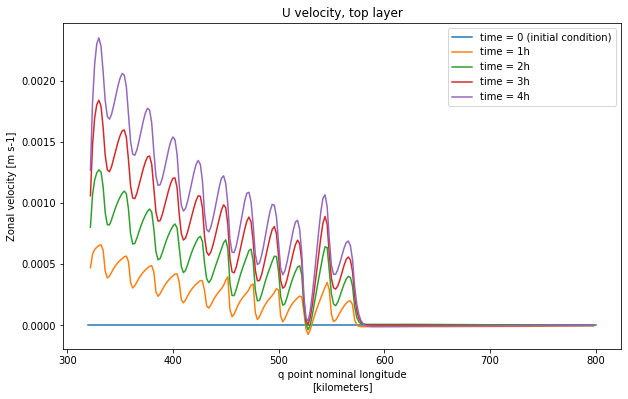

In [12]:
label = 'simpleshelftest2'
prog, ocean_static = open_files(label)
IC = open_IC(label)
fig,ax = plt.subplots(figsize = (10,6))
IC.u.isel(Time = 0).isel(Layer = 0, lath = 10).plot(label = 'time = 0 (initial condition)')

prog.u.isel(Time = 0).isel(zl = 0, yh = 10).plot(label = 'time = 1h')

prog.u.isel(Time = 1).isel(zl = 0, yh = 10).plot(label = 'time = 2h')

prog.u.isel(Time = 2).isel(zl = 0, yh = 10).plot(label = 'time = 3h')

prog.u.isel(Time = 3).isel(zl = 0, yh = 10).plot(label = 'time = 4h')

plt.legend()

plt.title('U velocity, top layer')


Text(0.5, 1.0, '')

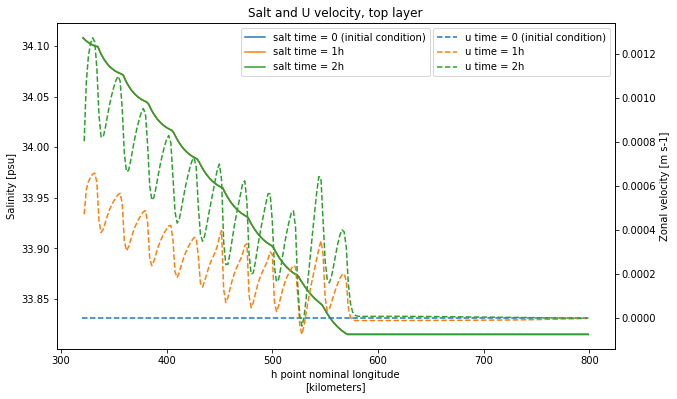

In [13]:
label = 'simpleshelftest2'
prog, ocean_static = open_files(label)
IC = open_IC(label)
fig,ax = plt.subplots(figsize = (10,6))
ax2 = ax.twinx()
IC.Salt.isel(Time = 0).isel(Layer = 0, lath = 10).plot(ax = ax, label = 'salt time = 0 (initial condition)')
prog.salt.isel(Time = 0).isel(zl = 0, yh = 10).plot(ax = ax, label = 'salt time = 1h')
prog.salt.isel(Time = 1).isel(zl = 0, yh = 10).plot(ax = ax, label = 'salt time = 2h')
ax.legend(loc = 'upper center')

IC.u.isel(Time = 0).isel(Layer = 0, lath = 10).plot(ax = ax2, label = 'u time = 0 (initial condition)', linestyle = '--')
prog.u.isel(Time = 0).isel(zl = 0, yh = 10).plot(ax = ax2,label = 'u time = 1h', linestyle = '--')
prog.u.isel(Time = 1).isel(zl = 0, yh = 10).plot(ax = ax2,label = 'u time = 2h', linestyle = '--')
ax2.legend()

ax.set_title('Salt and U velocity, top layer')
ax2.set_title('')


peak indices
[  7  19  31  42  54  66  78  90 102 113]
peak x values
[335. 359. 383. 405. 429. 453. 477. 501. 525. 547.]
diff peak indices
[12 12 11 12 12 12 12 12 11]


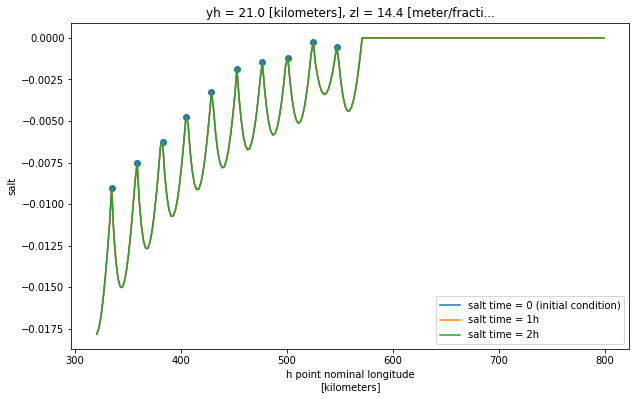

In [15]:
peaks, __ = find_peaks((IC.Salt-ideal_salt.values).isel(Time = 0).isel(Layer = 0, lath = 10).values, -0.0125,0.0001)
peaks
fig,ax = plt.subplots(figsize = (10,6))
ideal_salt = xr.zeros_like(IC.Salt) + (IC.eta.isel(Interface = 0)-IC.h.cumsum('Layer')+IC.h/2)*(34.55-33.8)/(-720) + 33.8
(IC.Salt-ideal_salt.values).isel(Time = 0).isel(Layer = 0, lath = 10).plot(ax = ax, label = 'salt time = 0 (initial condition)')
(prog.salt-ideal_salt.values).isel(Time = 0).isel(zl = 0, yh = 10).plot(ax = ax,label = 'salt time = 1h')
(prog.salt-ideal_salt.values).isel(Time = 1).isel(zl = 0, yh = 10).plot(ax = ax,label = 'salt time = 2h')
ax.legend()
plt.scatter(prog.xh.values[peaks],(IC.Salt-ideal_salt.values).isel(Time = 0).isel(Layer = 0, lath = 10).values[peaks],marker = 'o')
print('peak indices')
print(peaks)
print('peak x values')
print(prog.xh.values[peaks])
print('diff peak indices')
print(np.diff(peaks))

Text(0.5, 1.0, '')

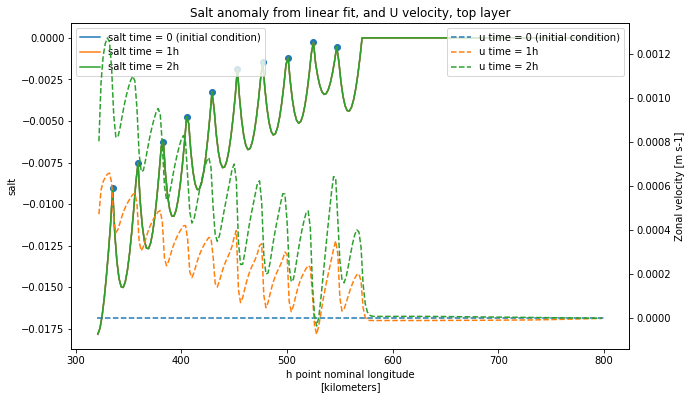

In [28]:
label = 'simpleshelftest2'
prog, ocean_static = open_files(label)
IC = open_IC(label)
fig,ax = plt.subplots(figsize = (10,6))
ax2 = ax.twinx()
ideal_salt = xr.zeros_like(IC.Salt) + (IC.eta.isel(Interface = 0)-IC.h.cumsum('Layer')+IC.h/2)*(34.55-33.8)/(-720) + 33.8
(IC.Salt-ideal_salt.values).isel(Time = 0).isel(Layer = 0, lath = 10).plot(ax = ax, label = 'salt time = 0 (initial condition)')
(prog.salt-ideal_salt.values).isel(Time = 0).isel(zl = 0, yh = 10).plot(ax = ax,label = 'salt time = 1h')
(prog.salt-ideal_salt.values).isel(Time = 1).isel(zl = 0, yh = 10).plot(ax = ax,label = 'salt time = 2h')
ax.legend(loc = 'upper left')
peaks, __ = find_peaks((IC.Salt-ideal_salt.values).isel(Time = 0).isel(Layer = 0, lath = 10).values, -0.0125,0.0001)
peaks
ax.scatter(prog.xh.values[peaks],(IC.Salt-ideal_salt.values).isel(Time = 0).isel(Layer = 0, lath = 10).values[peaks],marker = 'o')

IC.u.isel(Time = 0).isel(Layer = 0, lath = 10).plot(ax = ax2, label = 'u time = 0 (initial condition)', linestyle = '--')
prog.u.isel(Time = 0).isel(zl = 0, yh = 10).plot(ax = ax2,label = 'u time = 1h', linestyle = '--')
prog.u.isel(Time = 1).isel(zl = 0, yh = 10).plot(ax = ax2,label = 'u time = 2h', linestyle = '--')
ax2.legend()

ax.set_title('Salt anomaly from linear fit, and U velocity, top layer')
ax2.set_title('')


## plot an isomip one

Text(0.5, 1.0, 'Salinity, top layer')

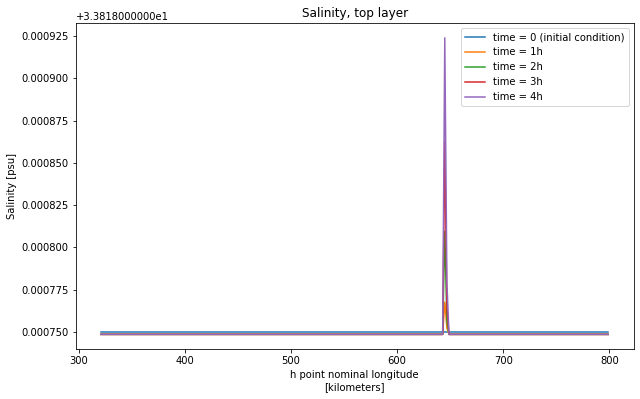

In [16]:
label = 'z-ISOMIPtopo-shelf'
prog, ocean_static = open_files(label)
IC = open_Initialstate(label)

fig,ax = plt.subplots(figsize = (10,6))
IC.Salt.isel(Time = 0).isel(Layer = 0, lath = 10).plot(label = 'time = 0 (initial condition)')

prog.salt.isel(Time = 0).isel(zl = 0, yh = 10).plot(label = 'time = 1h')

prog.salt.isel(Time = 1).isel(zl = 0, yh = 10).plot(label = 'time = 2h')

prog.salt.isel(Time = 2).isel(zl = 0, yh = 10).plot(label = 'time = 3h')

prog.salt.isel(Time = 3).isel(zl = 0, yh = 10).plot(label = 'time = 4h')

plt.legend()

plt.title('Salinity, top layer')



In [17]:
IC

<xarray.Dataset>
Dimensions:          (lath: 40, lonh: 240, latq: 41, lonq: 241, Layer: 20,
                      Interface: 21, Time: 1)
Coordinates:
  * lath             (lath) float64 1.0 3.0 5.0 7.0 9.0 ... 73.0 75.0 77.0 79.0
  * lonh             (lonh) float64 321.0 323.0 325.0 ... 795.0 797.0 799.0
  * latq             (latq) float64 0.0 2.0 4.0 6.0 8.0 ... 74.0 76.0 78.0 80.0
  * lonq             (lonq) float64 320.0 322.0 324.0 ... 796.0 798.0 800.0
  * Layer            (Layer) float64 18.0 54.0 90.0 126.0 ... 630.0 666.0 702.0
  * Interface        (Interface) float64 0.0 36.0 72.0 ... 648.0 684.0 720.0
  * Time             (Time) timedelta64[ns] 00:00:00
Data variables: (12/25)
    Temp             (Time, Layer, lath, lonh) float64 ...
    Salt             (Time, Layer, lath, lonh) float64 ...
    h                (Time, Layer, lath, lonh) float64 ...
    u                (Time, Layer, lath, lonq) float64 ...
    v                (Time, Layer, latq, lonh) float64 ...
    ave_ssh          (Time, lath, lonh) float64 ...
    ...               ...
    diffu            (Time, Layer, lath, lonq) float64 ...
    diffv            (Time, Layer, latq, lonh) float64 ...
    ubtav            (Time, lath, lonq) float64 ...
    vbtav            (Time, latq, lonh) float64 ...
    DTBT             (Time) timedelta64[ns] ...
    eta              (Time, Interface, lath, lonh) float64 ...
Attributes:
    filename:  ./Initial_state.nc

Text(0.5, 1.0, 'Eta, top layer')

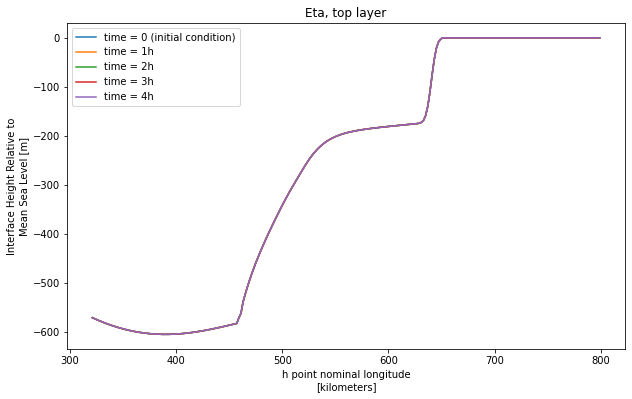

In [18]:
label = 'z-ISOMIPtopo-shelf'
prog, ocean_static = open_files(label)
IC = open_Initialstate(label)

fig,ax = plt.subplots(figsize = (10,6))
IC.eta.isel(Time = 0).isel(Interface = 0, lath = 10).plot(label = 'time = 0 (initial condition)')

prog.e.isel(Time = 0).isel(zi = 0, yh = 10).plot(label = 'time = 1h')

prog.e.isel(Time = 1).isel(zi = 0, yh = 10).plot(label = 'time = 2h')

prog.e.isel(Time = 2).isel(zi = 0, yh = 10).plot(label = 'time = 3h')

prog.e.isel(Time = 3).isel(zi = 0, yh = 10).plot(label = 'time = 4h')

plt.legend()

plt.title('Eta, top layer')



Text(0.5, 1.0, 'Eta, intial condition')

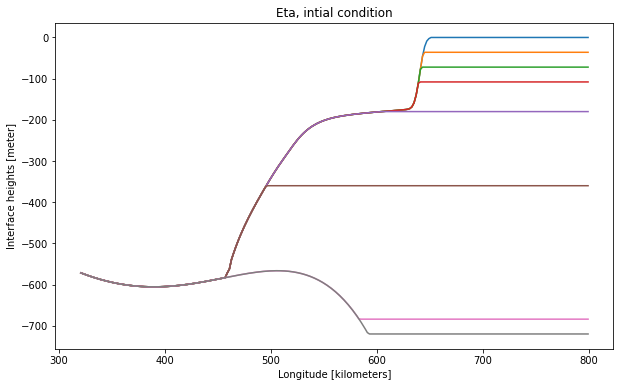

In [19]:
label = 'z-ISOMIPtopo-shelf'
prog, ocean_static = open_files(label)
IC = open_Initialstate(label)

fig,ax = plt.subplots(figsize = (10,6))
IC.eta.isel(Time = 0).isel(Interface = 0, lath = 10).plot()
IC.eta.isel(Time = 0).isel(Interface = 1, lath = 10).plot()
IC.eta.isel(Time = 0).isel(Interface = 2, lath = 10).plot()
IC.eta.isel(Time = 0).isel(Interface = 3, lath = 10).plot()
IC.eta.isel(Time = 0).isel(Interface = 5, lath = 10).plot()
IC.eta.isel(Time = 0).isel(Interface = 10, lath = 10).plot()
IC.eta.isel(Time = 0).isel(Interface = -2, lath = 10).plot()
IC.eta.isel(Time = 0).isel(Interface = -1, lath = 10).plot()


#plt.legend()

plt.title('Eta, intial condition')



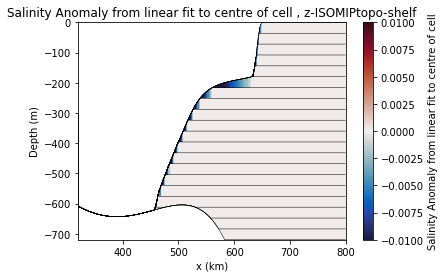

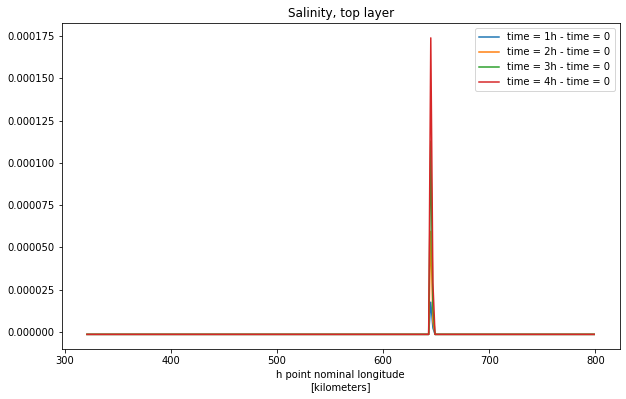

In [20]:
folder = 'z-ISOMIPtopo-shelf'
label = 'z-ISOMIPtopo-shelf'

fig, ax = plt.subplots()
prog, ocean_static = open_files(label)
IC = open_Initialstate(label)
x = 20

ideal_salt = xr.zeros_like(IC.Salt) + (IC.eta.isel(Interface = 0)-IC.h.cumsum('Layer')+IC.h/2)*(34.55-33.8)/(-720) + 33.8
plot(ax,x,time,0,IC.Salt-ideal_salt,"Salinity Anomaly from linear fit to centre of cell",-0.01,0.01,cm.cm.balance,ymax)
plt.show()

fig,ax = plt.subplots(figsize = (10,6))

IC_Salt = IC.Salt.isel(Time = 0).isel(Layer = 0, lath = 10).rename({'lonh':'xh'})
#IC_Salt.plot(label = 'time = 0 (initial condition)')

(prog.salt.isel(Time = 0).isel(zl = 0, yh = 10)-IC_Salt).plot(label = 'time = 1h - time = 0')

(prog.salt.isel(Time = 1).isel(zl = 0, yh = 10)-IC_Salt).plot(label = 'time = 2h - time = 0')

(prog.salt.isel(Time = 2).isel(zl = 0, yh = 10)-IC_Salt).plot(label = 'time = 3h - time = 0')

(prog.salt.isel(Time = 3).isel(zl = 0, yh = 10)-IC_Salt).plot(label = 'time = 4h - time = 0')

plt.legend()

plt.title('Salinity, top layer')

plt.show()


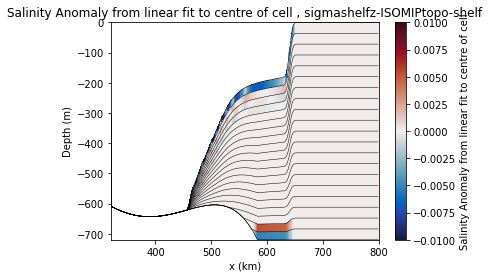

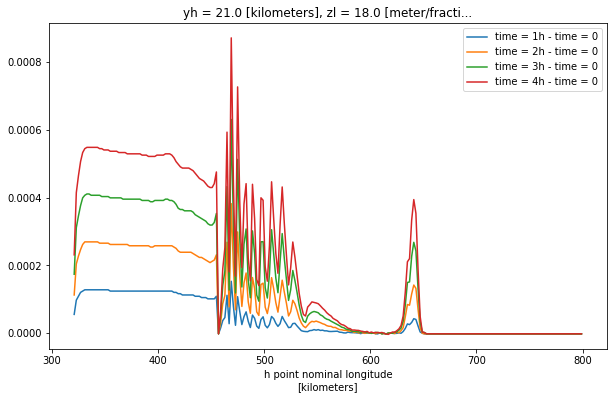

peak indices
[ 71  73  76  79  83  87  92  96 101 109 159]
peak x values
[463. 467. 473. 479. 487. 495. 505. 513. 523. 539. 639.]
diff peak indices
[ 2  3  3  4  4  5  4  5  8 50]


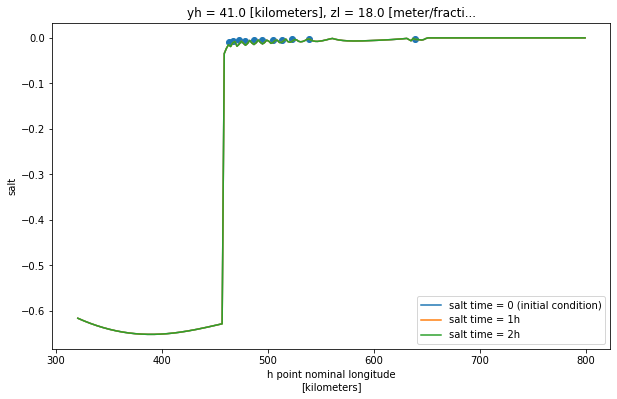

In [21]:
folder = 'sigmashelfz-ISOMIPtopo-shelf'
label = 'sigmashelfz-ISOMIPtopo-shelf'

fig, ax = plt.subplots()
prog, ocean_static = open_files(label)
IC = open_Initialstate(label)
x = 20

ideal_salt = xr.zeros_like(IC.Salt) + (IC.eta.isel(Interface = 0)-IC.h.cumsum('Layer')+IC.h/2)*(34.55-33.8)/(-720) + 33.8
plot(ax,x,time,0,IC.Salt-ideal_salt,"Salinity Anomaly from linear fit to centre of cell",-0.01,0.01,cm.cm.balance,ymax)
plt.show()

fig,ax = plt.subplots(figsize = (10,6))

IC_Salt = IC.Salt.isel(Time = 0).isel(Layer = 0, lath = 10).rename({'lonh':'xh'})
#IC_Salt.plot(label = 'time = 0 (initial condition)')

(prog.salt.isel(Time = 0).isel(zl = 0, yh = 10)-IC_Salt).plot(label = 'time = 1h - time = 0')

(prog.salt.isel(Time = 1).isel(zl = 0, yh = 10)-IC_Salt).plot(label = 'time = 2h - time = 0')

(prog.salt.isel(Time = 2).isel(zl = 0, yh = 10)-IC_Salt).plot(label = 'time = 3h - time = 0')

(prog.salt.isel(Time = 3).isel(zl = 0, yh = 10)-IC_Salt).plot(label = 'time = 4h - time = 0')

plt.legend()
plt.show()
peaks, __ = find_peaks((IC.Salt-ideal_salt.values).isel(Time = 0).isel(Layer = 0, lath = 10).values, -0.0125,0.0001)
peaks
fig,ax = plt.subplots(figsize = (10,6))
ideal_salt = xr.zeros_like(IC.Salt) + (IC.eta.isel(Interface = 0)-IC.h.cumsum('Layer')+IC.h/2)*(34.55-33.8)/(-720) + 33.8
(IC.Salt-ideal_salt.values).isel(Time = 0).isel(Layer = 0, lath =x).plot(ax = ax, label = 'salt time = 0 (initial condition)')
(prog.salt-ideal_salt.values).isel(Time = 0).isel(zl = 0, yh = x).plot(ax = ax,label = 'salt time = 1h')
(prog.salt-ideal_salt.values).isel(Time = 1).isel(zl = 0, yh = x).plot(ax = ax,label = 'salt time = 2h')
ax.legend()
plt.scatter(prog.xh.values[peaks],(IC.Salt-ideal_salt.values).isel(Time = 0).isel(Layer = 0, lath = 10).values[peaks],marker = 'o')
print('peak indices')
print(peaks)
print('peak x values')
print(prog.xh.values[peaks])
print('diff peak indices')
print(np.diff(peaks))
plt.show()



# Repeat for just topography and more complicated things

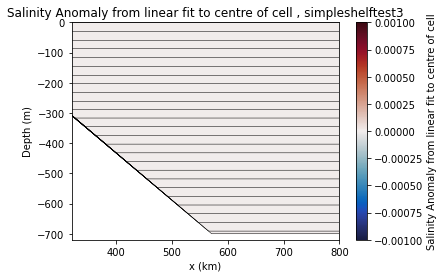

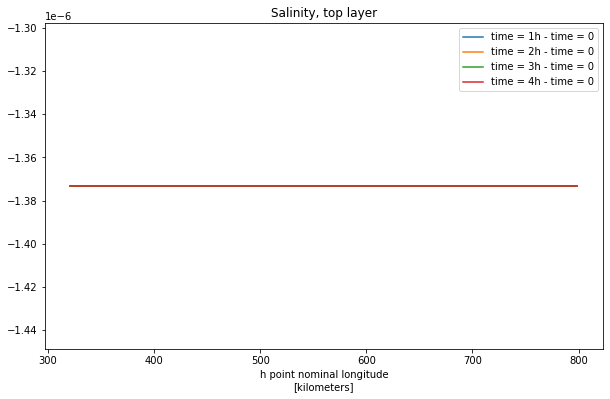

In [22]:
folder = 'simpleshelftest3'
label = 'simpleshelftest3'

fig, ax = plt.subplots()
prog, ocean_static = open_files(label)
IC = open_IC(label)
x = -1

ideal_salt = xr.zeros_like(IC.Salt) + (IC.eta.isel(Interface = 0)-IC.h.cumsum('Layer')+IC.h/2)*(34.55-33.8)/(-720) + 33.8
plot(ax,x,time,0,IC.Salt-ideal_salt,"Salinity Anomaly from linear fit to centre of cell",-0.001,0.001,cm.cm.balance,ymax)
plt.show()

prog, ocean_static = open_files(label)
IC = open_IC(label)

fig,ax = plt.subplots(figsize = (10,6))

IC_Salt = IC.Salt.isel(Time = 0).isel(Layer = 0, lath = 10).rename({'lonh':'xh'})
#IC_Salt.plot(label = 'time = 0 (initial condition)')

(prog.salt.isel(Time = 0).isel(zl = 0, yh = 10)-IC_Salt).plot(label = 'time = 1h - time = 0')

(prog.salt.isel(Time = 1).isel(zl = 0, yh = 10)-IC_Salt).plot(label = 'time = 2h - time = 0')

(prog.salt.isel(Time = 2).isel(zl = 0, yh = 10)-IC_Salt).plot(label = 'time = 3h - time = 0')

(prog.salt.isel(Time = 3).isel(zl = 0, yh = 10)-IC_Salt).plot(label = 'time = 4h - time = 0')

plt.legend()

plt.title('Salinity, top layer')

plt.show()


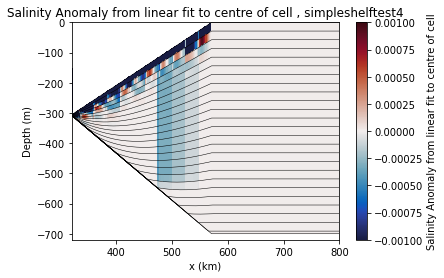

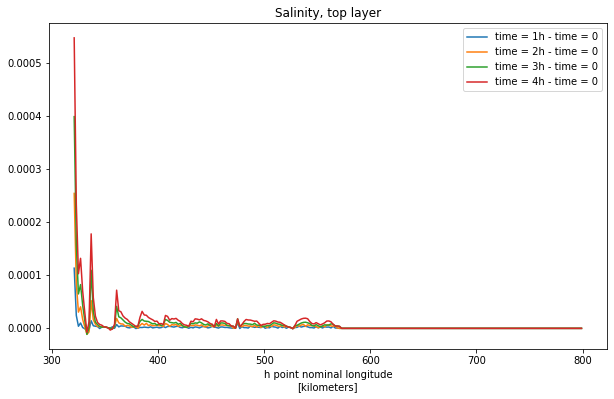

In [23]:
folder = 'simpleshelftest4'
label = 'simpleshelftest4'

fig, ax = plt.subplots()
prog, ocean_static = open_files(label)
IC = open_IC(label)
x = -1

ideal_salt = xr.zeros_like(IC.Salt) + (IC.eta.isel(Interface = 0)-IC.h.cumsum('Layer')+IC.h/2)*(34.55-33.8)/(-720) + 33.8
plot(ax,x,time,0,IC.Salt-ideal_salt,"Salinity Anomaly from linear fit to centre of cell",-0.001,0.001,cm.cm.balance,ymax)
plt.show()

prog, ocean_static = open_files(label)
IC = open_IC(label)

fig,ax = plt.subplots(figsize = (10,6))

IC_Salt = IC.Salt.isel(Time = 0).isel(Layer = 0, lath = 10).rename({'lonh':'xh'})
#IC_Salt.plot(label = 'time = 0 (initial condition)')

(prog.salt.isel(Time = 0).isel(zl = 0, yh = 10)-IC_Salt).plot(label = 'time = 1h - time = 0')

(prog.salt.isel(Time = 1).isel(zl = 0, yh = 10)-IC_Salt).plot(label = 'time = 2h - time = 0')

(prog.salt.isel(Time = 2).isel(zl = 0, yh = 10)-IC_Salt).plot(label = 'time = 3h - time = 0')

(prog.salt.isel(Time = 3).isel(zl = 0, yh = 10)-IC_Salt).plot(label = 'time = 4h - time = 0')

plt.legend()

plt.title('Salinity, top layer')

plt.show()


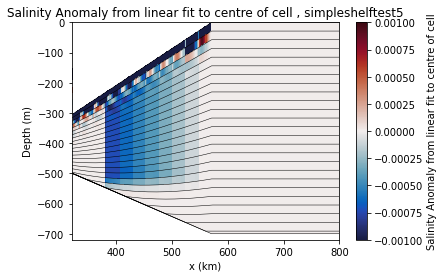

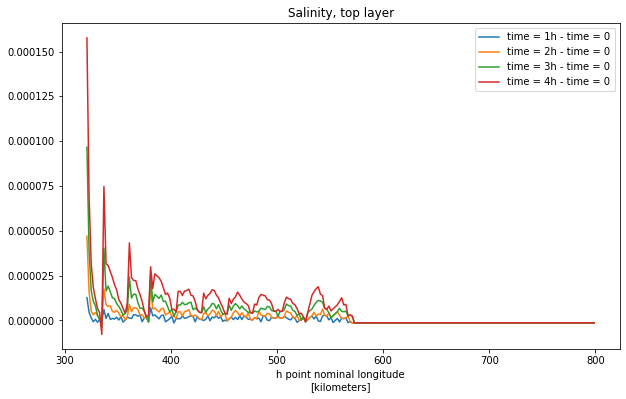

In [24]:
folder = 'simpleshelftest5'
label = 'simpleshelftest5'

fig, ax = plt.subplots()
prog, ocean_static = open_files(label)
IC = open_IC(label)
x = 10

ideal_salt = xr.zeros_like(IC.Salt) + (IC.eta.isel(Interface = 0)-IC.h.cumsum('Layer')+IC.h/2)*(34.55-33.8)/(-720) + 33.8
plot(ax,x,time,0,IC.Salt-ideal_salt,"Salinity Anomaly from linear fit to centre of cell",-0.001,0.001,cm.cm.balance,ymax)
plt.show()

prog, ocean_static = open_files(label)
IC = open_IC(label)

fig,ax = plt.subplots(figsize = (10,6))

IC_Salt = IC.Salt.isel(Time = 0).isel(Layer = 0, lath = 10).rename({'lonh':'xh'})
#IC_Salt.plot(label = 'time = 0 (initial condition)')

(prog.salt.isel(Time = 0).isel(zl = 0, yh = 10)-IC_Salt).plot(label = 'time = 1h - time = 0')

(prog.salt.isel(Time = 1).isel(zl = 0, yh = 10)-IC_Salt).plot(label = 'time = 2h - time = 0')

(prog.salt.isel(Time = 2).isel(zl = 0, yh = 10)-IC_Salt).plot(label = 'time = 3h - time = 0')

(prog.salt.isel(Time = 3).isel(zl = 0, yh = 10)-IC_Salt).plot(label = 'time = 4h - time = 0')

plt.legend()

plt.title('Salinity, top layer')

plt.show()


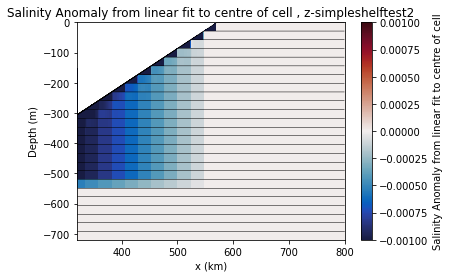

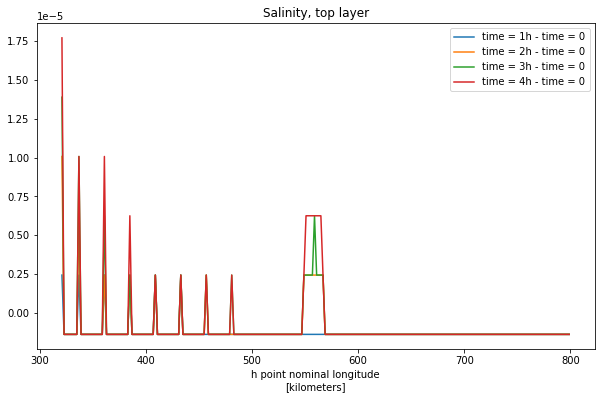

In [25]:
folder = 'z-simpleshelftest2'
label = 'z-simpleshelftest2'

fig, ax = plt.subplots()
prog, ocean_static = open_files(label)
IC = open_IC(label)
x = 10

ideal_salt = xr.zeros_like(IC.Salt) + (IC.eta.isel(Interface = 0)-IC.h.cumsum('Layer')+IC.h/2)*(34.55-33.8)/(-720) + 33.8
plot(ax,x,time,0,IC.Salt-ideal_salt,"Salinity Anomaly from linear fit to centre of cell",-0.001,0.001,cm.cm.balance,ymax)
plt.show()

prog, ocean_static = open_files(label)
IC = open_IC(label)

fig,ax = plt.subplots(figsize = (10,6))

IC_Salt = IC.Salt.isel(Time = 0).isel(Layer = 0, lath = 10).rename({'lonh':'xh'})
#IC_Salt.plot(label = 'time = 0 (initial condition)')

(prog.salt.isel(Time = 0).isel(zl = 0, yh = 10)-IC_Salt).plot(label = 'time = 1h - time = 0')

(prog.salt.isel(Time = 1).isel(zl = 0, yh = 10)-IC_Salt).plot(label = 'time = 2h - time = 0')

(prog.salt.isel(Time = 2).isel(zl = 0, yh = 10)-IC_Salt).plot(label = 'time = 3h - time = 0')

(prog.salt.isel(Time = 3).isel(zl = 0, yh = 10)-IC_Salt).plot(label = 'time = 4h - time = 0')

plt.legend()

plt.title('Salinity, top layer')

plt.show()


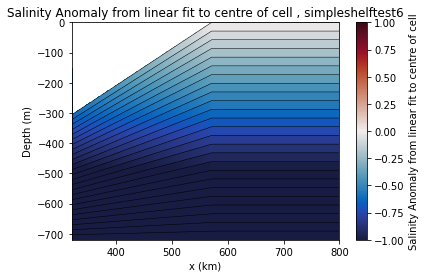

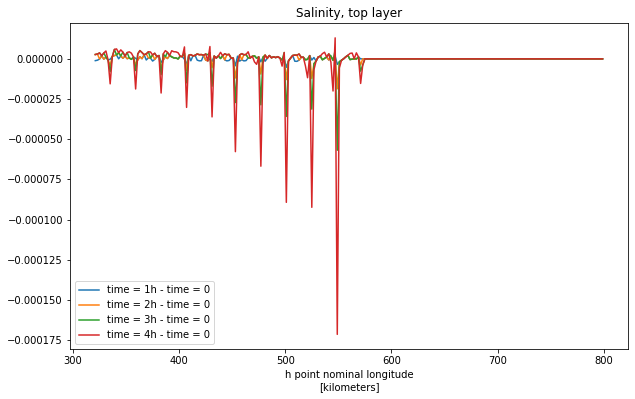

In [35]:
folder = 'simpleshelftest6'
label = 'simpleshelftest6'

fig, ax = plt.subplots()
prog, ocean_static = open_files(label)
IC = open_IC(label)
x = 10

ideal_salt = xr.zeros_like(IC.Salt) + (IC.eta.isel(Interface = 0)-IC.h.cumsum('Layer')+IC.h/2)*(34.55-33.8)/(-720) + 33.8
plot(ax,x,time,0,IC.Salt-ideal_salt,"Salinity Anomaly from linear fit to centre of cell",-1,1,cm.cm.balance,ymax)
plt.show()

fig,ax = plt.subplots(figsize = (10,6))

IC_Salt = IC.Salt.isel(Time = 0).isel(Layer = 0, lath = 10).rename({'lonh':'xh'})
#IC_Salt.plot(label = 'time = 0 (initial condition)')

(prog.salt.isel(Time = 0).isel(zl = 0, yh = 10)-IC_Salt).plot(label = 'time = 1h - time = 0')

(prog.salt.isel(Time = 1).isel(zl = 0, yh = 10)-IC_Salt).plot(label = 'time = 2h - time = 0')

(prog.salt.isel(Time = 2).isel(zl = 0, yh = 10)-IC_Salt).plot(label = 'time = 3h - time = 0')

(prog.salt.isel(Time = 3).isel(zl = 0, yh = 10)-IC_Salt).plot(label = 'time = 4h - time = 0')

plt.legend()

plt.title('Salinity, top layer')

plt.show()


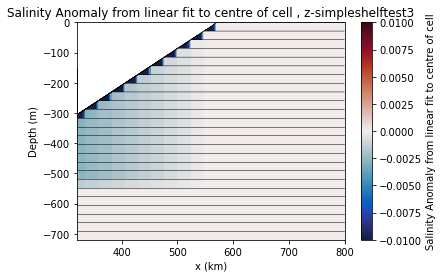

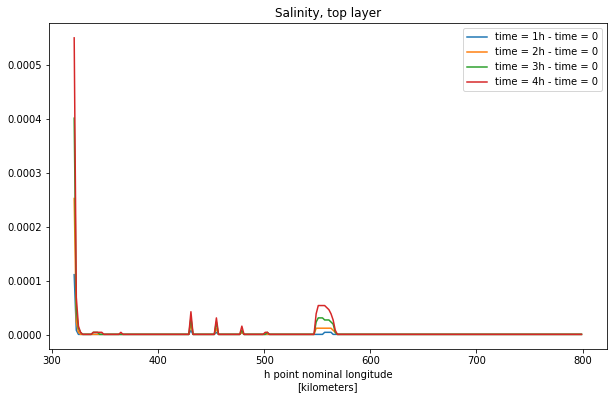

In [41]:
folder = 'z-simpleshelftest3'
label = 'z-simpleshelftest3'

fig, ax = plt.subplots()
prog, ocean_static = open_files(label)
IC = open_IC(label)
x = 10

ideal_salt = xr.zeros_like(IC.Salt) + (IC.eta.isel(Interface = 0)-IC.h.cumsum('Layer')+IC.h/2)*(36-34)/(-720) + 34
plot(ax,x,time,0,IC.Salt-ideal_salt,"Salinity Anomaly from linear fit to centre of cell",-0.01,0.01,cm.cm.balance,ymax)
#plot(ax,x,time,0,IC.Salt,"Salinity Anomaly from linear fit to centre of cell",34,36,cm.cm.balance,ymax)
plt.show()

prog, ocean_static = open_files(label)
IC = open_IC(label)

fig,ax = plt.subplots(figsize = (10,6))

IC_Salt = IC.Salt.isel(Time = 0).isel(Layer = 0, lath = 10).rename({'lonh':'xh'})
#IC_Salt.plot(label = 'time = 0 (initial condition)')

(prog.salt.isel(Time = 0).isel(zl = 0, yh = 10)-IC_Salt).plot(label = 'time = 1h - time = 0')

(prog.salt.isel(Time = 1).isel(zl = 0, yh = 10)-IC_Salt).plot(label = 'time = 2h - time = 0')

(prog.salt.isel(Time = 2).isel(zl = 0, yh = 10)-IC_Salt).plot(label = 'time = 3h - time = 0')

(prog.salt.isel(Time = 3).isel(zl = 0, yh = 10)-IC_Salt).plot(label = 'time = 4h - time = 0')

plt.legend()

plt.title('Salinity, top layer')

plt.show()


# try to make symmetric shelves

-6.027078052284196e-05
-304.654052734375


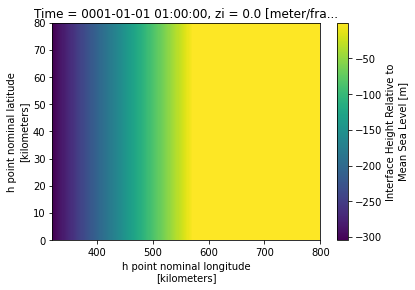

In [67]:
#fig, ax = plt.subplots()
prog, ocean_static = open_files('simpleshelftest2')
#ideal_salt = xr.zeros_like(prog.salt) + (prog.e.isel(zi = 0)-prog.h.cumsum('zl')+prog.h/2)*(34.55-33.8)/(-720) + 33.8
#plot(ax,x,time,0,ideal_salt,"so",33,36,cm.cm.haline,ymax)

prog.e.isel(zi = 0,Time = 0).plot()
print(prog.e.isel(zi = 0,Time = 0).max().values)
print(prog.e.isel(zi = 0,Time = 0).min().values)



-310.0
-700.0


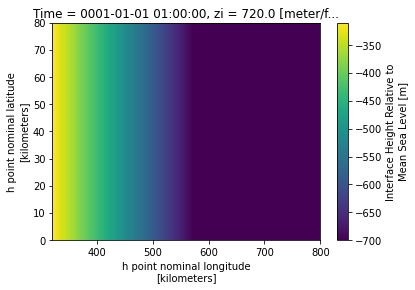

In [69]:
prog, ocean_static = open_files('simpleshelftest3')
#ideal_salt = xr.zeros_like(prog.salt) + (prog.e.isel(zi = 0)-prog.h.cumsum('zl')+prog.h/2)*(34.55-33.8)/(-720) + 33.8
#plot(ax,x,time,0,ideal_salt,"so",33,36,cm.cm.haline,ymax)

prog.e.isel(zi = -1,Time = 0).plot()
print(prog.e.isel(zi = -1,Time = 0).max().values)
print(prog.e.isel(zi = -1,Time = 0).min().values)



In [70]:
## make ncfile for simpleshelftest3-shallower with same 304.5m maximum.

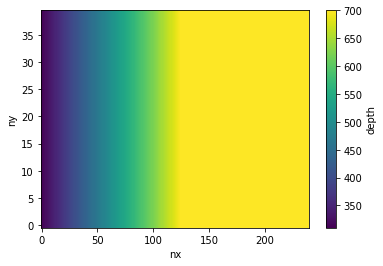

700.0
395.35


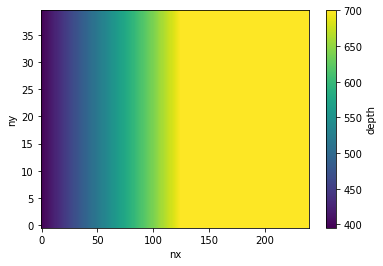

In [81]:
topog_390 = xr.open_dataset('topog.nc')
topog_390.depth.plot()
plt.show()
topog_304_5 = (topog_390-700)*(304.65/390) +700
topog_304_5.depth.plot()
print(topog_304_5.depth.max().values)
print(topog_304_5.depth.min().values)
plt.show()

topog_304_5.to_netcdf('topog_304_65.nc')